In [41]:
import sys
import os
import gc
import pandas as pd
import numpy as np
import lightgbm as lgbm
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [42]:
# Submission
submission_no = 8

# Files and Paths
files_ = {
    "historical_transactions": "data/historical_transactions.csv",
    "merchants": "data/merchants.csv",
    "new_merchant_transactions": "data/new_merchant_transactions.csv",
    "train": "data/train.csv",
    "test": "data/test.csv"
}

# Paths
model_data_dir = "model_input_bins/"
model_output_dir = "model_output/"

if not os.path.exists(model_data_dir):
    os.makedirs(model_data_dir)
    
if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)

In [52]:
def rf_reg_main():
    
    # Assemble bins
    train = pd.concat(
        objs=[pd.read_csv(model_data_dir+x) for x in os.listdir(model_data_dir) if x[:5] == 'train'],
        axis=0
    )
    test = pd.concat(
        objs=[pd.read_csv(model_data_dir+x) for x in os.listdir(model_data_dir) if x[:4] == 'test'],
        axis=0
    )
    
    # Confirm shape
    assert train.shape[0] == 201917
    assert test.shape[0] == 123623
    
    # Set final DataFrame
    cols = [x for x in list(train.columns) if x != 'target']
    train_X = train[cols]
    test_X = test[cols]
    train_y = train.target
    
    # Param Grid
    param_grid = [
        {'n_estimators': [27, 28, 30], 
         'max_features': [9, 10],
         'min_samples_split': [10],
         'min_samples_leaf': [8, 10, 12]}
    ]
    rf_reg = RandomForestRegressor()
    grid_search = GridSearchCV(rf_reg, param_grid, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(train_X, train_y)
    print(param_grid)
    print(grid_search.best_params_)
    
    # Fit Model
    rf_reg = RandomForestRegressor(n_estimators=grid_search.best_params_.get('n_estimators'), 
                                   criterion='mse',
                                   max_depth=None,
                                   min_samples_split=grid_search.best_params_.get('min_samples_split'),
                                   min_samples_leaf=grid_search.best_params_.get('min_samples_leaf'),
                                   max_features=grid_search.best_params_.get('max_features'))
    rf_reg.fit(train_X, train_y)
    importances = rf_reg.feature_importances_
    
    # Names
    feats = {}
    for feature, importance in zip(train_X.columns, importances):
        feats[feature] = importance #add the name/value pair 

    df_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    df_importances.sort_values(by=['Gini-importance'], ascending=False, inplace=True)
    print(list(df_importances.index))
    
    indices = np.argsort(importances)[::-1]
    fig = plt.figure(figsize=(14, 8))
    plt.title("Feature importances")
    plt.bar(df_importances.index, df_importances['Gini-importance'], color="r", align="center")
    plt.xticks(range(train_X.shape[1]), feats)
    plt.xticks(rotation=90)
    plt.xlim([-1, train_X.shape[1]])
    plt.show()
    
    # Score
    score = rf_reg.score(train_X, train_y)
    result = "Submission {} \nModel: {} \nScore: {}".format(str(submission_no), "rf_reg", str(score))
    print(score)
    
    # Write Score to test with Submission Number
    outF = open(model_output_dir + "submission{}_score_rf_reg.txt".format(str(submission_no)), "w")
    outF.write(result)
    for k, v in grid_search.best_params_.items():
        outF.write("{}: {}\n".format(str(k), str(v)))
    outF.close()
    
    # Predict
    yhat = rf_reg.predict(test_X)
    #rmse = sqrt(mean_squared_error(test_y, yhat))
    #print("RMSE: {}".format(str(rmse)))
    submission = pd.DataFrame({'card_id': list(test['card_id']), 
                              'target': list(yhat)})
    assert submission.shape == (123623, 2)
    submission.to_csv(model_output_dir + "submission{}_rf_reg.csv".format(str(submission_no)), index=False)

In [53]:
def lgbm_main():
    """
    """
    
    # Assemble bins
    train = pd.concat(
        objs=[pd.read_csv(model_data_dir+x) for x in os.listdir(model_data_dir) if x[:5] == 'train'],
        axis=0
    )
    test = pd.concat(
        objs=[pd.read_csv(model_data_dir+x) for x in os.listdir(model_data_dir) if x[:4] == 'test'],
        axis=0
    )
    
    # Confirm shape
    assert train.shape[0] == 201917
    assert test.shape[0] == 123623
    
    # Set final DataFrame
    cols = [x for x in list(train.columns) if x != 'target']
    train_X = train[cols]
    test_X = test[cols]
    train_y = train.target
    
    # Param Grid
    param_grid = [
        {'n_estimators': [37,40, 45, 50], 
         'num_leaves': [25],
         'learning_rate': [0.05]}
    ]
    gbm = lgbm.LGBMRegressor()
    grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring="neg_mean_squared_error")
    grid_search.fit(train_X, train_y)
    print(param_grid)
    print(grid_search.best_params_)
    
    # Model
    gbm = lgbm.LGBMRegressor(num_leaves=grid_search.best_params_.get("num_leaves"),
                            learning_rate=grid_search.best_params_.get("learing_rate"),
                            n_estimators=grid_search.best_params_.get("n_estimators"))
    
    # Split train_1, train_2
    # def rmsle(y_true, y_pred):
    #    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False
    def rmse(y_true, yhat):
        return sqrt(mean_squared_error(y_true, yhat))
    
    #train_x1, train_x2, train_y1, train_y2 = train_test_split(train_X, train_y, 
    #                                                          test_size=0.33, random_state=42)
    #gbm.fit(train_x1, train_y1,
    #        eval_set=[(train_x2, train_y2)],
    #        eval_metric=rmse,
    #        early_stopping_rounds=5)
    gbm.fit(train_X, train_y)
    
    # Feature Importances
    importances = gbm.feature_importances_
    feats = {}
    for feature, importance in zip(train_X.columns, importances):
        feats[feature] = importance #add the name/value pair 

    df_importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    df_importances.sort_values(by=['Gini-importance'], ascending=False, inplace=True)
    print(list(df_importances.index))
    
    indices = np.argsort(importances)[::-1]
    fig = plt.figure(figsize=(14, 8))
    plt.title("Feature importances")
    plt.bar(df_importances.index, df_importances['Gini-importance'], color="r", align="center")
    plt.xticks(range(train_X.shape[1]), feats)
    plt.xticks(rotation=90)
    plt.xlim([-1, train_X.shape[1]])
    plt.show()
    
    # Score
    score = gbm.score(train_X, train_y)
    result = "Submission {} \nModel: {} \nScore: {}".format(str(submission_no), "lgbm", str(score))
    print(score)
    
    # Predict
    yhat = gbm.predict(test_X)
    #rmse = sqrt(mean_squared_error(train_y, yhat))
    #print("RMSE: {}".format(str(rmse)))
    submission = pd.DataFrame({'card_id': list(test['card_id']), 
                              'target': list(yhat)})
    assert submission.shape == (123623, 2)
    submission.to_csv(model_output_dir + "submission{}_lgbm.csv".format(str(submission_no)), index=False)
    
    # Write Score to test with Submission Number
    outF = open(model_output_dir + "submission{}_score_lgbm.txt".format(str(submission_no)), "w")
    outF.write(result)
    for k, v in grid_search.best_params_.items():
        outF.write("{}: {}\n".format(str(k), str(v)))
    outF.close()


[{'n_estimators': [27, 28, 30], 'max_features': [9, 10], 'min_samples_split': [10], 'min_samples_leaf': [8, 10, 12]}]
{'max_features': 10, 'min_samples_split': 10, 'n_estimators': 30, 'min_samples_leaf': 12}
['category_1_N_hist_sum', 'category_2_1_hist_sum', 'category_3_B_hist_std', 'PC_1_city_id_hist_purchase_count', 'PC_3_city_id_hist_purchase_count', 'avg_sales_lag12_x_trans_auth_purchase_rate_hist', 'avg_sales_lag6_x_trans_auth_purchase_rate_new', 'avg_sales_lag12_x_trans_auth_purchase_rate_new', 'avg_sales_lag3_x_trans_auth_purchase_rate_new', 'category_3_B_hist_sum', 'PC_2_city_id_hist_purchase_count', 'installments_1_std_hist_y', 'category_2_1_hist_std', 'category_3_C_hist_sum', 'avg_sales_lag3_x_trans_auth_purchase_rate_hist', 'installments_std_hist', 'category_2_99_hist_sum', 'category_1_Y_hist_std', 'avg_sales_lag6_x_trans_auth_purchase_rate_hist', 'PC_0_city_id_hist_purchase_count', 'elapsed_time', 'category_3_C_hist_std', 'installments_1_sum_hist_y', 'purchase_date_ptp', 'p

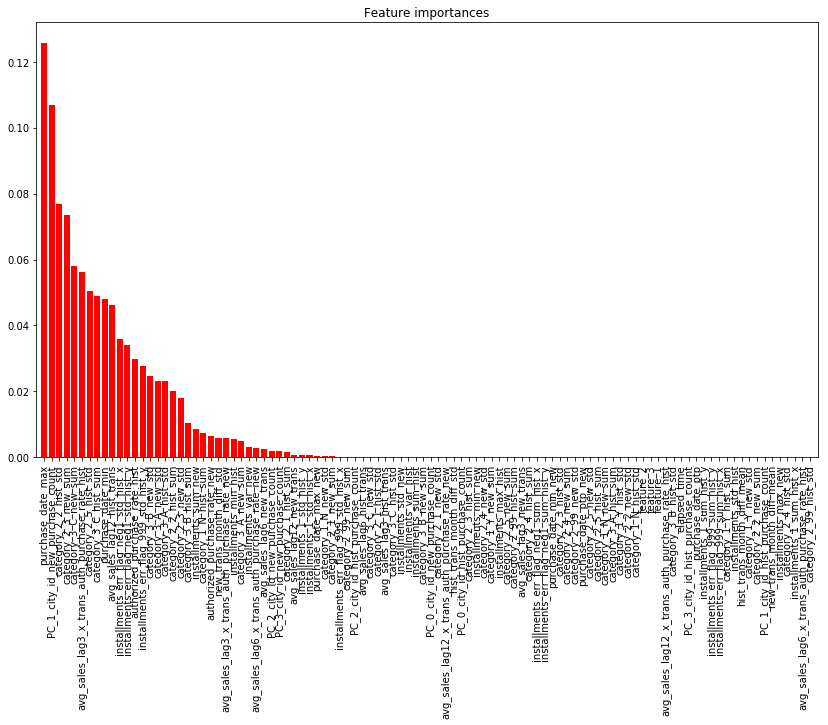

0.8077711202311725


In [54]:
rf_reg_main()

In [ ]:
#lgbm_main()